In [45]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import json

---

# Choosing the Best "zulo40"

In [46]:
models_folder = "ModelBuild/"
results_file = "/results.json"

models = [#"Metadata (efnet (zulo40))",
          #"Metadata (efnet) 02",
          #"Metadata (efnet) 03",
          #"Metadata (efnet) 04",
          #"Metadata (efnet) 05",
          "Metadata (efnet) 06",]

models_mae = {} 
for model in models:
    with open(models_folder + model + results_file) as f:
        data = json.load(f)
    avg_mae = 0
    for fold in data:
        avg_mae += data[fold]["Best Mae"]
    avg_mae /= len(data)
    models_mae[model] = avg_mae

best_model = min(models_mae, key=models_mae.get)
print("Best Model based on CV MAE:")
print(f"{best_model} with MAE {models_mae[best_model]}")

Best Model based on CV MAE:
Metadata (efnet) 06 with MAE 1.153822660446167


Fold 0
Model stopped at epoch 66 with mae 0.9903514385223389
Fold 1
Model stopped at epoch 53 with mae 1.1910563707351685
Fold 2
Model stopped at epoch 38 with mae 1.2800601720809937


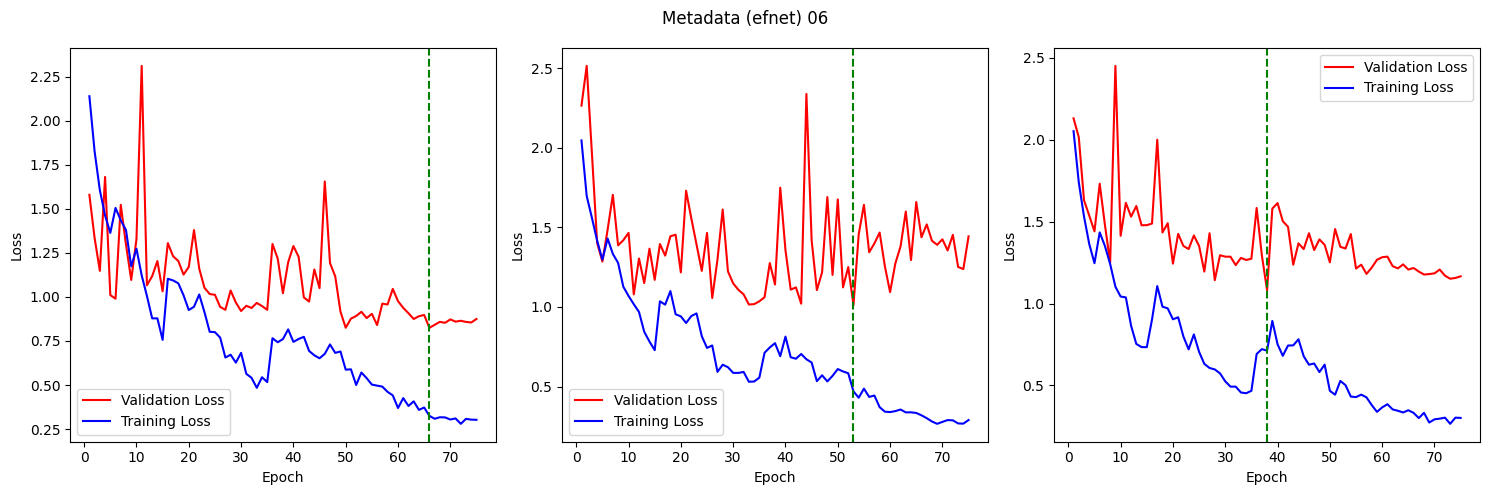

In [47]:
with open(f"ModelBuild/{best_model}/results.json") as json_file:
    metadata_zulo40 = json.load(json_file)

plt.figure(figsize=(15, 5))
plt.suptitle(f"{best_model}")
for fold in metadata_zulo40:
    print(f"{fold}")
    print(f"Model stopped at epoch {metadata_zulo40[fold]['Results']['model_from_epoch']}")

    plt.subplot(1, 3, int(fold.split(" ")[-1])+1)
    val_loss = metadata_zulo40[fold]['Results']['val_loss']
    train_loss = metadata_zulo40[fold]['Results']['train_loss']

    epochs = range(1, len(val_loss) + 1)
    plt.plot(epochs, val_loss, 'r', label='Validation Loss')
    plt.plot(epochs, train_loss, 'b', label='Training Loss')
    plt.axvline(x=int(metadata_zulo40[fold]['Results']['model_from_epoch'][:2]), color='g', linestyle='--')
    plt.legend()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')

plt.tight_layout()
plt.show()

**fazer mean cv val e train: 3 até 37, 2 até 53, 1 até 65 epochs**

train mae - full train dataset

In [48]:
train_pred = pd.read_csv(f"ModelBuild/{best_model}/submission_train.csv")
train_true = pd.read_csv("Train.csv")

# remove duplicates in train_pred
train_pred.drop_duplicates(subset=['ID'], keep='last', inplace=True)

# merge same id, with sum in boil_nbr and pan_nbr
train_true = train_true.groupby(['ID']).agg({'boil_nbr': 'sum', 'pan_nbr': 'sum'}).reset_index()

# one column only for true set
train_true_df = {
    "ID": [],
    "Target": [],
}
for index, row in train_true.iterrows():
    train_true_df["ID"].append(f'{row["ID"]}_boil')
    train_true_df["Target"].append(row["boil_nbr"])
    train_true_df["ID"].append(f'{row["ID"]}_pan')
    train_true_df["Target"].append(row["pan_nbr"])
train_true = pd.DataFrame(train_true_df)

# compute mae
train_pred = train_pred.merge(train_true, on="ID", how="inner")
train_pred["ae"] = abs(train_pred["Target_x"] - train_pred["Target_y"])
train_pred["mae"] = train_pred["ae"].mean()

print(f"Train MAE: {train_pred['mae'].values[0]}")
print(f"Validation mean MAE during CV: {1.153822660446167}")
print(f"Test MAE: {0.843495934}")

Train MAE: 0.5126811594202898
Validation mean MAE during CV: 1.153822660446167
Test MAE: 0.843495934


# Choosing the Best YOLO